In [50]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, validation_curve, cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Load in Housing Data

In [2]:
train = pd.read_csv('data-science-comp-f2020/train_final.csv').iloc[:,1:-1]
test = pd.read_csv('data-science-comp-f2020/test_final.csv').iloc[:,1:-1]
y = pd.DataFrame(train.Y)
train = train.drop(columns="Y")
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
0,25884,1,33.63,118596,1,0,118595,125738,1,3,...,-2.266430,1945,118450,119184,1,121372,1,1,1,2
1,34346,1,10.62,118041,1,0,117902,130913,1,1,...,-0.305612,15385,117945,292795,1,259173,1,1,1,1
2,34923,1,1.77,118327,1,0,117961,124402,1,2,...,2.015561,7547,118933,290919,1,118784,1,1,1,1
3,80926,1,30.09,118300,1,0,117961,301218,1,0,...,-3.172501,4933,118458,118331,1,307024,1,1,1,2
4,4674,1,1.77,119921,1,0,119920,302830,1,0,...,0.573767,13836,142145,4673,1,128230,1,1,1,620


In [3]:
#Samples from both train and test
all_data = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:-1]))

#### Some useful functions for below

In [24]:
global model_counter
model_counter = 0
def export_test(preds, model, params):
    global model_counter
    model_counter += 1
    model_name = datetime.today().strftime('%Y_%m_%d') + "xgboost_" + str(model_counter)
    model.save_model(f'models/{model_name}.model')
    
    model_params = f"models/{model_name}_params.json"
    with open(model_params, 'w') as fp:
        json.dump(params, fp)
        
    ids = pd.read_csv('data-science-comp-f2020/test_final.csv').iloc[:,0]
    np.shape(ids)
    temp = pd.concat([ids, preds], axis=1)
    temp.to_csv(f'results/{model_name}.csv',index=False,header=True)
    print("Saved model:", model_name)

#### Brief Data Exploration

In [25]:
train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04
mean,43007.775865,1.044375,11.770938,118323.581456,1.044436,0.050052,117089.674113,169730.178600,1.041812,4.976317,...,0.293940,25894.316914,119045.099005,184622.040835,1.047305,125959.667765,1.044558,1.045718,1.041934,3.271890e+04
std,33611.182771,0.264806,353.187115,4518.059755,0.265601,0.293892,10261.292970,69396.677853,0.258226,65.629620,...,1.728999,36086.993946,18321.987129,100590.811845,0.306239,31091.344158,0.262576,0.266874,0.246597,3.184929e+06
min,-1.000000,1.000000,1.770000,23779.000000,1.000000,0.000000,4292.000000,4673.000000,1.000000,0.000000,...,-7.446045,25.000000,4674.000000,3130.000000,1.000000,117879.000000,1.000000,1.000000,1.000000,1.000000e+00
25%,20311.000000,1.000000,1.770000,118096.000000,1.000000,0.000000,117961.000000,117906.000000,1.000000,0.000000,...,-0.704562,4554.000000,118395.000000,118398.000000,1.000000,118274.000000,1.000000,1.000000,1.000000,1.000000e+00
50%,35527.000000,1.000000,1.770000,118300.000000,1.000000,0.000000,117961.000000,128130.000000,1.000000,0.000000,...,1.000000,13234.000000,118929.000000,119095.000000,1.000000,118568.000000,1.000000,1.000000,1.000000,2.000000e+00
75%,74240.500000,1.000000,3.540000,118386.000000,1.000000,0.000000,117961.000000,234498.500000,1.000000,1.000000,...,1.000000,38902.000000,120539.000000,290919.000000,1.000000,120006.000000,1.000000,1.000000,1.000000,9.000000e+00
max,312152.000000,7.000000,43910.160000,286791.000000,9.000000,10.000000,311178.000000,311867.000000,11.000000,5036.000000,...,7.398682,311696.000000,286792.000000,308574.000000,18.000000,311867.000000,8.000000,8.000000,7.000000,4.042886e+08


<AxesSubplot:>

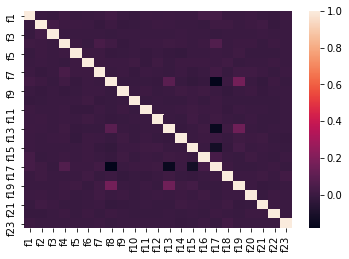

In [26]:
corr = train.corr()
sns.heatmap(corr)

In [27]:
counts = y['Y'].value_counts()
counts

1    15435
0      948
Name: Y, dtype: int64

### Training Models

#### Trying XGBoost
First attempt is just vanilla, no tuning

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
if "Y" in X_train.columns:
    del data["Y"]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest_submit = xgb.DMatrix(test)
params = {
    'eta': 0.1, 
    'max_depth': 20,  
    'objective': 'multi:softprob',  
    'num_class': 2, 
    'verbosity':1} 

steps = 20
num_round = 10

In [29]:
model = xgb.train(params, dtrain, steps)

In [30]:
soft_preds = pd.DataFrame(model.predict(dtest))
soft_preds_result = pd.DataFrame(model.predict(dtest)).iloc[:, 1:]
soft_preds_result.columns = ["Y"]
soft_preds_result.head()

,Y
0,0.929146
1,0.688694
2,0.528397
3,0.934351
4,0.916486


In [31]:
model_counter

0

In [70]:
export_test(soft_preds, model, params)

AttributeError: 'DataFrame' object has no attribute 'save_model'

Trying submission with hard predictions

In [37]:
hard_preds = pd.DataFrame([np.argmax(line) for line in soft_preds])
hard_preds.columns = ["Y"]
np.shape(hard_preds)

(2, 1)

In [71]:
export_test(soft_preds_result, model, params)

AttributeError: 'DataFrame' object has no attribute 'save_model'

Trying out Cross Validation

In [56]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
if "Y" in X_train.columns:
    del data["Y"]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest_submit = xgb.DMatrix(test)
params = {
    'learning_rate': 0.1, 
    'colsample_bytree': 0.3,
    'max_depth': 20,  
    'objective': 'multi:softprob',  
    'num_class': 2, 
    'eval_metric': 'mlogloss',
    'alpha': 10,
    'verbosity':1} 
evals = [(dtest,'eval'), (dtrain,'train')]
steps = 20
num_round = 10

In [57]:
model = xgb.cv(dtrain=dtrain, params=params, nfold=5, metrics="mlogloss", as_pandas=True, seed=123)
model

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,0.619238,0.000303,0.619248,0.000505
1,0.558836,0.000557,0.558858,0.000988
2,0.506893,0.001840,0.506962,0.001939
3,0.463035,0.000881,0.463127,0.002973
4,0.425247,0.002475,0.425337,0.002635
5,0.393985,0.001979,0.394084,0.003055
6,0.366682,0.003240,0.366790,0.003366
7,0.343104,0.003540,0.343211,0.004803
8,0.323165,0.003995,0.323346,0.005635
9,0.306431,0.004294,0.306598,0.006562


In [63]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
print('Train Counts: 0=%d, 1=%d, Test Counts: 0=%d, 1=%d' % (train_counts[0], train_counts[1], test_counts[0], test_counts[1]))

Train Counts: 0=767, 1=12339, Test Counts: 0=181, 1=3096


In [103]:
evals = [(dtest,'eval'), (dtrain,'train')]
booster = "gbtree"
results = pd.DataFrame(columns=['accuracy','roc_auc','recall', 'precision'])
for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for n_estimators in [10, 20, 50, 100]:
        for colsample_bytree in [0, 0.2, 0.4, 0.6, 0.8]:
            for alpha in [0, 0.01, 0.05]:
                for gamma in [0, 0.01, 0.05]:
                    for max_depth in [3, 5, 10, 20]:
                        print("TRAINING ON PARAMS:", str(params))
                        params = {'learning_rate': learning_rate, 'colsample_bytree': colsample_bytree, 'max_depth': max_depth, 
                          'objective': 'multi:softprob',  'num_class': 2, 'eval_metric': "mlogloss", 'n_estimators': n_estimators,
                          'alpha': alpha, "gamma":gamma}
                        model = xgb.XGBClassifier(learning_rate=learning_rate, colsample_bytree=colsample_bytree, max_depth=max_depth, 
                                  objective='multi:softprob',num_class=2, eval_metric="mlogloss", n_estimators=n_estimators,
                                  alpha=alpha, gamma=gamma, verbosity=1)
                        scores = []
                        for scoring in ['accuracy','roc_auc','recall', 'precision']:
                            kfold = StratifiedKFold(n_splits=10, random_state=7)
                            run_results = cross_val_score(model, X_train, y_train, scoring=scoring, cv=kfold)
                            print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))
                            scores.append(results.mean()*100)
                        results.loc[str(params)] = scores
results.to_csv(f'training_results/run1.csv',index=False,header=True)

TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 64.16% (4.01%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 65.17% (4.21%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 66.05% (3.78%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 10, 

accuracy : 94.15% (0.03%)
roc_auc : 65.69% (3.90%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 65.70% (3.89%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 64.23% (4.03%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 65.13% (4.15%)
recall : 100.00% (0.

accuracy : 94.15% (0.03%)
roc_auc : 79.85% (2.35%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.55% (2.47%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.86% (2.66%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 78.72% (2.28%)
recall :

accuracy : 94.16% (0.04%)
roc_auc : 79.46% (2.83%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.16% (0.05%)
roc_auc : 80.74% (2.63%)
recall : 100.00% (0.00%)
precision : 94.16% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.33% (0.08%)
roc_auc : 83.09% (2.81%)
recall : 100.00% (0.00%)
precision : 94.32% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.48% (0.12%)
roc_auc : 83.61% (2.87%)
recall : 99.99% (0

accuracy : 94.41% (0.09%)
roc_auc : 83.19% (2.63%)
recall : 99.99% (0.02%)
precision : 94.40% (0.10%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.19% (2.81%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 81.24% (3.10%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.25%)
roc_auc : 83.75% (2.79%)
recall : 99.98% (0.03%

accuracy : 95.99% (0.24%)
roc_auc : 83.52% (2.50%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.26%)
roc_auc : 84.66% (2.21%)
recall : 99.98% (0.03%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.16% (3.02%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.24% (3.06%)
recall : 100.00

roc_auc : 80.20% (3.32%)
recall : 99.95% (0.04%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.95% (0.30%)
roc_auc : 81.74% (2.77%)
recall : 99.89% (0.09%)
precision : 95.97% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.91% (0.31%)
roc_auc : 82.56% (2.95%)
recall : 99.84% (0.08%)
precision : 95.98% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 79.66% (2.71%)
recall : 100.00% (0.00%)
precision : 

roc_auc : 79.43% (2.36%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.71% (2.42%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.19% (2.47%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.28% (2.55%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%

accuracy : 94.15% (0.03%)
roc_auc : 80.12% (2.31%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.43% (2.26%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.93% (2.62%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.73% (2.67%)
recall : 100.00% (0.00%

accuracy : 94.15% (0.03%)
roc_auc : 82.49% (2.50%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.92% (2.58%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.42% (2.44%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.83% (2.61%)
recall : 100.0

accuracy : 94.23% (0.07%)
roc_auc : 81.78% (2.68%)
recall : 100.00% (0.00%)
precision : 94.23% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.50% (0.18%)
roc_auc : 84.62% (2.62%)
recall : 100.00% (0.00%)
precision : 94.48% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.66% (0.20%)
roc_auc : 85.32% (2.53%)
recall : 100.00% (0.00%)
precision : 94.63% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.16% (0.04%)
roc_auc : 80.42% (2.84%)
recall :

TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.55% (2.75%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.53% (3.28%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 96.00% (0.24%)
roc_auc : 83.95% (2.73%)
recall : 99.98% (0.03%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 

accuracy : 96.00% (0.23%)
roc_auc : 83.70% (2.70%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 84.66% (2.58%)
recall : 99.98% (0.03%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.04% (2.59%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.98% (0.25%)
roc_auc : 80.57% (3.16%)
recall : 99.98%

accuracy : 95.98% (0.25%)
roc_auc : 80.76% (2.88%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.94% (0.29%)
roc_auc : 81.85% (2.61%)
recall : 99.92% (0.06%)
precision : 95.94% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.94% (0.30%)
roc_auc : 82.47% (2.35%)
recall : 99.90% (0.06%)
precision : 95.95% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.03% (2.67%)
recall : 100.00% (0.

accuracy : 94.15% (0.03%)
roc_auc : 79.05% (2.42%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 79.59% (2.72%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.27% (2.65%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.29% (2.66%)
recall : 100.00

accuracy : 94.15% (0.03%)
roc_auc : 84.91% (2.89%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.58% (3.15%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.86% (3.13%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 84.21% (2.88%)
recall : 100.00% (

TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 83.92% (2.76%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 84.51% (2.78%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.16% (0.04%)
roc_auc : 80.93% (2.71%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_byt

accuracy : 94.16% (0.04%)
roc_auc : 80.91% (2.79%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.25% (0.06%)
roc_auc : 82.17% (3.04%)
recall : 100.00% (0.00%)
precision : 94.25% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.49% (0.13%)
roc_auc : 84.88% (2.68%)
recall : 100.00% (0.00%)
precision : 94.47% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.66% (0.20%)
roc_auc : 85.60% (2.42%)
recall : 100.00% (

accuracy : 95.99% (0.24%)
roc_auc : 85.26% (2.58%)
recall : 99.98% (0.05%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.58% (2.77%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.48% (3.32%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 96.02% (0.24%)
roc_auc : 83.96% (2.86%)
recall : 100.

TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.97% (0.27%)
roc_auc : 81.97% (2.53%)
recall : 99.94% (0.06%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.97% (0.31%)
roc_auc : 83.00% (2.32%)
recall : 99.93% (0.08%)
precision : 95.96% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.05% (2.52%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 

accuracy : 95.99% (0.24%)
roc_auc : 80.08% (2.60%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.97% (0.25%)
roc_auc : 80.62% (3.28%)
recall : 99.98% (0.05%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.98% (0.27%)
roc_auc : 81.93% (2.76%)
recall : 99.95% (0.05%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.98% (0.30%)
roc_auc : 82.65% (2.55%)
recall : 99

accuracy : 94.15% (0.03%)
roc_auc : 81.48% (2.63%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.21% (2.53%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.78% (2.60%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 81.43% (2.62%)
recall : 100.00% (

accuracy : 94.15% (0.03%)
roc_auc : 84.25% (2.71%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 84.92% (2.75%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.78% (2.75%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.85% (2.74%)
recall : 10

precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.23% (0.07%)
roc_auc : 82.30% (2.95%)
recall : 100.00% (0.00%)
precision : 94.23% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.45% (0.12%)
roc_auc : 85.14% (2.73%)
recall : 100.00% (0.00%)
precision : 94.43% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.56% (0.19%)
roc_auc : 86.13% (2.43%)
recall : 100.00% (0.00%)
precision : 94.54% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0

accuracy : 94.53% (0.16%)
roc_auc : 85.83% (2.49%)
recall : 100.00% (0.00%)
precision : 94.51% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.16% (0.04%)
roc_auc : 80.85% (2.81%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.22% (0.08%)
roc_auc : 82.15% (2.99%)
recall : 100.00% (0.00%)
precision : 94.22% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.43% (0.12%)
roc_auc : 84.99% (2.65%)
recall

TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.02% (0.24%)
roc_auc : 84.27% (2.92%)
recall : 100.00% (0.00%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.01% (0.24%)
roc_auc : 85.60% (2.43%)
recall : 99.99% (0.02%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.71% (2.88%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_b

accuracy : 95.99% (0.24%)
roc_auc : 80.29% (2.64%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.25%)
roc_auc : 80.85% (3.32%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.97% (0.27%)
roc_auc : 82.62% (2.61%)
recall : 99.94% (0.06%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.001, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.30%)
roc_auc : 83.43% (2.28%)
recall : 99.94% (

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 66.08% (3.73%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 64.08% (4.06%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 65.13% (4.17%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth':

accuracy : 94.15% (0.03%)
roc_auc : 65.15% (4.11%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 65.77% (3.83%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 65.78% (3.82%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 64.24% (4.01%)
recall : 100.0

accuracy : 94.15% (0.03%)
roc_auc : 78.55% (2.08%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.85% (2.36%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.50% (2.44%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.87% (2.57%)
recall : 

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.50% (0.14%)
roc_auc : 83.64% (2.63%)
recall : 99.99% (0.02%)
precision : 94.49% (0.14%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.16% (0.04%)
roc_auc : 79.52% (2.85%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.17% (0.06%)
roc_auc : 80.70% (2.68%)
recall : 100.00% (0.00%)
precision : 94.17% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4,

accuracy : 95.99% (0.24%)
roc_auc : 81.30% (3.12%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.25%)
roc_auc : 83.99% (2.78%)
recall : 99.98% (0.03%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.98% (0.25%)
roc_auc : 84.67% (2.39%)
recall : 99.96% (0.07%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.34% (2.96%)
recall : 100.00% (0.00%)
pre

accuracy : 95.99% (0.24%)
roc_auc : 80.32% (2.91%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.22% (2.99%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 83.68% (2.62%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.25%)
roc_auc : 84.50% (2.12%)
recall : 

accuracy : 95.90% (0.33%)
roc_auc : 82.45% (2.90%)
recall : 99.85% (0.08%)
precision : 95.97% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 79.56% (2.65%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.97% (0.26%)
roc_auc : 80.33% (3.50%)
recall : 99.97% (0.04%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.94% (0.30%)
roc_auc : 81.93% (2.83%)
recall : 99

accuracy : 94.15% (0.03%)
roc_auc : 80.35% (2.51%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.49% (2.56%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.38% (2.36%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 79.70% (2.55%)
recall : 100.00% (0.00%

accuracy : 94.15% (0.03%)
roc_auc : 81.02% (2.59%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.76% (2.96%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 83.24% (3.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.36% (2.16%)
recall : 100.00% (0.00%)
p

accuracy : 94.15% (0.03%)
roc_auc : 80.43% (2.25%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.00% (2.57%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.70% (2.45%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 83.13% (2.49%)
recall : 

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.73% (0.19%)
roc_auc : 85.28% (2.30%)
recall : 100.00% (0.00%)
precision : 94.70% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.16% (0.04%)
roc_auc : 80.49% (2.91%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.25% (0.06%)
roc_auc : 81.97% (2.64%)
recall : 100.00% (0.00%)
precision : 94.24% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_byt

accuracy : 95.99% (0.24%)
roc_auc : 81.63% (3.25%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 96.00% (0.24%)
roc_auc : 84.00% (2.96%)
recall : 99.98% (0.03%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 84.89% (2.38%)
recall : 99.97% (0.05%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.71% (2.90%)
recall : 100.00% (0

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.01% (2.56%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.25%)
roc_auc : 80.63% (3.38%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.95% (0.32%)
roc_auc : 82.25% (2.47%)
recall : 99.91% (0.08%)
precision : 95.95% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max

accuracy : 95.94% (0.29%)
roc_auc : 81.95% (2.68%)
recall : 99.92% (0.06%)
precision : 95.94% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.95% (0.31%)
roc_auc : 82.75% (2.58%)
recall : 99.91% (0.07%)
precision : 95.95% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.03% (2.60%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.25%)
roc_auc : 80.64% (3.19%)
recall : 99.98% 

accuracy : 94.15% (0.03%)
roc_auc : 79.92% (2.64%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.31% (2.71%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.41% (2.70%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 78.88% (2.50%)
recall : 100.0

accuracy : 94.15% (0.03%)
roc_auc : 80.60% (3.04%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 82.11% (3.17%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 84.63% (2.90%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 85.46% (2.77%)
recall : 100.00% (

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 85.13% (2.73%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.19% (0.08%)
roc_auc : 81.06% (2.77%)
recall : 100.00% (0.00%)
precision : 94.18% (0.08%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.32% (0.06%)
roc_auc : 82.53% (2.83%)
recall : 100.00% (0.00%)
precision : 94.31% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 

accuracy : 94.32% (0.06%)
roc_auc : 82.43% (2.90%)
recall : 100.00% (0.00%)
precision : 94.31% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.69% (0.20%)
roc_auc : 85.15% (2.63%)
recall : 100.00% (0.00%)
precision : 94.66% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.84% (0.16%)
roc_auc : 85.95% (2.25%)
recall : 100.00% (0.00%)
precision : 94.81% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.19% (0.08%)
roc_auc : 81.00% (2.80%)
recall : 100.00% 

accuracy : 95.99% (0.24%)
roc_auc : 80.74% (2.80%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.71% (3.29%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 96.00% (0.24%)
roc_auc : 84.39% (2.61%)
recall : 99.99% (0.02%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 85.62% (2.22%)
recall : 9

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.93% (0.35%)
roc_auc : 83.58% (2.38%)
recall : 99.89% (0.11%)
precision : 95.95% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.15% (2.52%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.25%)
roc_auc : 80.61% (3.32%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 

accuracy : 95.99% (0.25%)
roc_auc : 80.55% (3.31%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.96% (0.27%)
roc_auc : 82.14% (2.33%)
recall : 99.94% (0.08%)
precision : 95.94% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.96% (0.32%)
roc_auc : 83.26% (2.20%)
recall : 99.91% (0.09%)
precision : 95.96% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.80% (2.41%)
recall : 10

accuracy : 94.15% (0.03%)
roc_auc : 79.97% (2.39%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 81.13% (2.61%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 81.87% (2.69%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.27% (2.60%)
recall : 100.00% (0.0

accuracy : 94.16% (0.05%)
roc_auc : 85.88% (2.78%)
recall : 100.00% (0.00%)
precision : 94.16% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.78% (2.75%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.36% (2.76%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.01}
accuracy : 94.16% (0.05%)
roc_auc : 85.00% (2.87%)
recall : 

precision : 94.27% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.64% (0.19%)
roc_auc : 85.93% (2.73%)
recall : 100.00% (0.00%)
precision : 94.61% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.80% (0.19%)
roc_auc : 86.81% (2.54%)
recall : 100.00% (0.00%)
precision : 94.76% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.16% (0.04%)
roc_auc : 81.20% (2.60%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 

accuracy : 94.16% (0.04%)
roc_auc : 81.17% (2.61%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.28% (0.07%)
roc_auc : 82.74% (2.59%)
recall : 100.00% (0.00%)
precision : 94.27% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.59% (0.18%)
roc_auc : 85.83% (2.64%)
recall : 100.00% (0.00%)
precision : 94.57% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.76% (0.18%)
roc_auc : 86.67% (2.39%)
recall

TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.00% (0.24%)
roc_auc : 86.49% (2.23%)
recall : 99.98% (0.03%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.11% (2.66%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 82.31% (2.83%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytr

roc_auc : 81.21% (2.93%)
recall : 99.98% (0.05%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.27%)
roc_auc : 83.50% (2.27%)
recall : 99.94% (0.07%)
precision : 95.94% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.30%)
roc_auc : 84.72% (2.11%)
recall : 99.92% (0.08%)
precision : 95.95% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.005, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.61% (2.41%)
recall : 100.00% (0.00%)
precision : 95.92%

accuracy : 94.15% (0.03%)
roc_auc : 63.93% (4.13%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 65.23% (4.18%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 66.14% (3.90%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 66.12% (3.87%)
recall : 100.00% (0.00%)
pr

accuracy : 94.15% (0.03%)
roc_auc : 65.87% (3.81%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 64.20% (4.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 65.24% (4.09%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 65.79% (3.79%)
recall : 100.00% (

accuracy : 94.15% (0.03%)
roc_auc : 81.40% (2.45%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.79% (2.69%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 78.48% (2.12%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 79.77% (2.45%)
recall : 100.0

accuracy : 94.18% (0.07%)
roc_auc : 80.76% (2.75%)
recall : 100.00% (0.00%)
precision : 94.18% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.36% (0.10%)
roc_auc : 83.01% (2.66%)
recall : 100.00% (0.00%)
precision : 94.35% (0.09%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.51% (0.13%)
roc_auc : 83.84% (2.09%)
recall : 100.00% (0.00%)
precision : 94.49% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.04%)
roc_auc : 79.50% (2.83%)
recall : 100.00% (0.

accuracy : 95.99% (0.24%)
roc_auc : 80.33% (2.97%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.31% (3.05%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 83.80% (2.82%)
recall : 99.98% (0.03%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.25%)
roc_auc : 84.63% (2.27%)
recall : 99.97% (0.05%

roc_auc : 84.41% (2.42%)
recall : 99.97% (0.05%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.35% (2.98%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.23% (3.05%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 96.01% (0.24%)
roc_auc : 83.89% (2.74%)
recall : 100.00% (0.00%)
precision : 95

accuracy : 95.93% (0.32%)
roc_auc : 81.92% (2.66%)
recall : 99.88% (0.10%)
precision : 95.96% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.89% (0.35%)
roc_auc : 82.76% (2.40%)
recall : 99.83% (0.10%)
precision : 95.97% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 79.56% (2.69%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.96% (0.27%)
roc_auc : 80.25% (3.53%)
recall : 99.96% 

accuracy : 94.15% (0.03%)
roc_auc : 80.00% (2.31%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.32% (2.60%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.46% (2.62%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 79.39% (2.22%)
recall : 100.00% (0.00%)
p

accuracy : 94.15% (0.03%)
roc_auc : 80.31% (2.32%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.12% (2.84%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.78% (3.09%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.16% (0.05%)
roc_auc : 83.43% (2.88%)
recall : 100.00% (0.0

accuracy : 94.15% (0.03%)
roc_auc : 83.19% (2.69%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.42% (2.22%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.03% (2.67%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 82.78% (2.82%)
recall : 100

accuracy : 94.60% (0.17%)
roc_auc : 84.75% (2.66%)
recall : 100.00% (0.00%)
precision : 94.57% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.79% (0.19%)
roc_auc : 85.44% (2.22%)
recall : 100.00% (0.00%)
precision : 94.76% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.16% (0.04%)
roc_auc : 80.47% (2.92%)
recall : 100.00% (0.00%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.28% (0.07%)
roc_auc : 81.98% (2.74%)
recall : 100.0

roc_auc : 81.75% (3.16%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.00% (0.24%)
roc_auc : 84.13% (2.70%)
recall : 99.98% (0.03%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 85.01% (2.03%)
recall : 99.98% (0.05%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.76% (2.79%)
recall : 100.00% (0.00%)
precision : 95.92% (0.2

accuracy : 95.99% (0.24%)
roc_auc : 80.17% (2.55%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.25%)
roc_auc : 80.63% (3.22%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.95% (0.32%)
roc_auc : 82.55% (2.27%)
recall : 99.92% (0.09%)
precision : 95.95% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.94% (0.36%)
roc_auc : 83.60% (2.17%)
recall : 99.89% (0.11%)

accuracy : 95.94% (0.33%)
roc_auc : 82.80% (2.41%)
recall : 99.90% (0.07%)
precision : 95.95% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.11% (2.56%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.25%)
roc_auc : 80.58% (3.22%)
recall : 99.98% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.94% (0.28%)
roc_auc : 82.23% (2.33%)
recall : 99.93

accuracy : 94.15% (0.03%)
roc_auc : 80.96% (2.67%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.39% (2.55%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 78.82% (2.58%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.21% (2.85%)
recall : 100.00% (0.

accuracy : 94.15% (0.03%)
roc_auc : 82.38% (3.28%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.05%)
roc_auc : 85.09% (3.15%)
recall : 100.00% (0.00%)
precision : 94.15% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.05%)
roc_auc : 86.03% (3.02%)
recall : 100.00% (0.00%)
precision : 94.16% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.66% (3.07%)
recall : 100.00% (0.

accuracy : 94.43% (0.06%)
roc_auc : 81.25% (2.69%)
recall : 100.00% (0.00%)
precision : 94.41% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.53% (0.13%)
roc_auc : 82.80% (2.78%)
recall : 100.00% (0.00%)
precision : 94.51% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.94% (0.20%)
roc_auc : 85.72% (2.60%)
recall : 100.00% (0.00%)
precision : 94.90% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.03% (0.14%)
roc_auc : 86.24% (2.17%)
recall : 100.00% (0.0

accuracy : 95.00% (0.13%)
roc_auc : 86.26% (2.29%)
recall : 100.00% (0.00%)
precision : 94.96% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.43% (0.06%)
roc_auc : 81.25% (2.71%)
recall : 100.00% (0.00%)
precision : 94.41% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.53% (0.12%)
roc_auc : 82.71% (2.84%)
recall : 100.00% (0.00%)
precision : 94.51% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.91% (0.19%)
roc_auc : 85.65% (2.66%)
recall : 100

accuracy : 96.01% (0.24%)
roc_auc : 85.08% (2.54%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 86.03% (2.06%)
recall : 99.98% (0.04%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.00% (2.61%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 82.06% (2.95%)
recall : 100.00

accuracy : 95.98% (0.26%)
roc_auc : 80.93% (3.10%)
recall : 99.98% (0.05%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.28%)
roc_auc : 83.20% (2.04%)
recall : 99.94% (0.07%)
precision : 95.94% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.33%)
roc_auc : 84.04% (2.11%)
recall : 99.90% (0.10%)
precision : 95.95% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.35% (2.47%)
recall : 100.00% (0.00%

accuracy : 94.15% (0.03%)
roc_auc : 79.71% (2.38%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.14% (2.78%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.62% (2.64%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 83.06% (2.50%)
recall : 100.00% (0.00%)

accuracy : 94.15% (0.03%)
roc_auc : 83.08% (2.53%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 79.83% (2.33%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.22% (2.79%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 82.58% (2.64%)
recall : 100.00

accuracy : 94.17% (0.06%)
roc_auc : 85.68% (2.93%)
recall : 100.00% (0.00%)
precision : 94.17% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.17% (0.06%)
roc_auc : 86.51% (2.83%)
recall : 100.00% (0.00%)
precision : 94.17% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.02% (2.61%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.82% (2.78%)
recall : 10

accuracy : 94.45% (0.11%)
roc_auc : 83.38% (2.66%)
recall : 100.00% (0.00%)
precision : 94.44% (0.11%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.93% (0.18%)
roc_auc : 86.63% (2.61%)
recall : 100.00% (0.00%)
precision : 94.89% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.03% (0.14%)
roc_auc : 87.42% (2.36%)
recall : 99.99% (0.02%)
precision : 94.99% (0.14%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.35% (0.08%)
roc_auc : 81.85% (2.47%)
recall : 100.00% (

TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 81.75% (2.42%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 82.86% (2.69%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 96.01% (0.24%)
roc_auc : 86.27% (2.36%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'ma

accuracy : 96.01% (0.24%)
roc_auc : 86.20% (2.31%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.01% (0.24%)
roc_auc : 86.89% (2.29%)
recall : 99.99% (0.02%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.73% (2.46%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 82.81% (2.66%)
recall : 

accuracy : 95.99% (0.25%)
roc_auc : 81.33% (2.71%)
recall : 99.99% (0.02%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.98% (0.26%)
roc_auc : 84.31% (2.23%)
recall : 99.96% (0.07%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.96% (0.29%)
roc_auc : 85.08% (2.05%)
recall : 99.92% (0.07%)
precision : 95.95% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.01, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.77% (2.43%)
recall : 10

accuracy : 94.15% (0.03%)
roc_auc : 63.90% (4.11%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 65.54% (4.02%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 67.20% (3.81%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 67.24% (3.78%)
recall : 100.00% (0.00%)
pr

accuracy : 94.16% (0.05%)
roc_auc : 82.47% (2.92%)
recall : 100.00% (0.00%)
precision : 94.15% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 78.74% (2.25%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.61% (2.68%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.24% (2.71%)
recall : 100.00% (0.00%)

accuracy : 94.15% (0.03%)
roc_auc : 82.05% (2.61%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.16% (0.05%)
roc_auc : 82.61% (2.74%)
recall : 100.00% (0.00%)
precision : 94.15% (0.05%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 78.64% (2.26%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.50% (2.66%)
recall : 10

accuracy : 94.23% (0.06%)
roc_auc : 81.13% (2.69%)
recall : 100.00% (0.00%)
precision : 94.23% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.44% (0.08%)
roc_auc : 83.79% (2.48%)
recall : 99.99% (0.02%)
precision : 94.43% (0.09%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.67% (0.20%)
roc_auc : 84.44% (2.54%)
recall : 99.99% (0.02%)
precision : 94.65% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.16% (0.04%)
roc_auc : 80.22% (2.57%)
recall : 100.

accuracy : 95.99% (0.24%)
roc_auc : 80.97% (2.72%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 81.74% (2.67%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.25%)
roc_auc : 84.59% (2.18%)
recall : 99.98% (0.05%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.97% (0.24%)
roc_auc : 85.37% (2.27%)
recall : 99.95% (0.06%

accuracy : 95.93% (0.35%)
roc_auc : 83.27% (1.91%)
recall : 99.85% (0.12%)
precision : 95.98% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 80.14% (2.50%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.97% (0.27%)
roc_auc : 80.95% (3.08%)
recall : 99.97% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.93% (0.34%)
roc_auc : 82.61% (2.53%)
recall : 99.89% (0.10%)
pr

accuracy : 95.93% (0.33%)
roc_auc : 82.55% (2.46%)
recall : 99.90% (0.09%)
precision : 95.95% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.90% (0.35%)
roc_auc : 83.14% (2.15%)
recall : 99.86% (0.11%)
precision : 95.95% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 80.10% (2.45%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.97% (0.27%)
roc_auc : 80.89% (3.15%)
recall : 99.9

accuracy : 94.15% (0.03%)
roc_auc : 80.54% (2.55%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.71% (2.70%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 82.53% (2.42%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.74% (2.34%)
recall : 100.00% 

accuracy : 94.15% (0.03%)
roc_auc : 80.48% (2.41%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.01% (2.68%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.06%)
roc_auc : 84.28% (2.53%)
recall : 100.00% (0.00%)
precision : 94.16% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.19% (0.05%)
roc_auc : 85.21% (2.44%)
recall : 100.00% (0.0

accuracy : 95.14% (0.15%)
roc_auc : 86.26% (2.27%)
recall : 99.98% (0.03%)
precision : 95.11% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.93% (0.21%)
roc_auc : 81.67% (2.59%)
recall : 100.00% (0.00%)
precision : 94.89% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.03% (0.24%)
roc_auc : 82.82% (2.48%)
recall : 100.00% (0.00%)
precision : 94.98% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.17% (0.19%)
roc_auc : 85.72% (2.48%)
recall : 100.00% (0.00%)


accuracy : 95.12% (0.21%)
roc_auc : 85.96% (2.12%)
recall : 100.00% (0.00%)
precision : 95.08% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.15% (0.12%)
roc_auc : 86.37% (2.52%)
recall : 99.99% (0.02%)
precision : 95.11% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.93% (0.21%)
roc_auc : 81.61% (2.63%)
recall : 100.00% (0.00%)
precision : 94.89% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.00% (0.21%)
roc_auc : 82.77% (2.54%)
recall : 100

accuracy : 95.99% (0.24%)
roc_auc : 82.26% (2.48%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.25%)
roc_auc : 85.26% (2.29%)
recall : 99.98% (0.05%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 85.60% (2.43%)
recall : 99.97% (0.05%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.47% (2.44%)
recall : 100.

accuracy : 95.99% (0.24%)
roc_auc : 80.35% (2.65%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.26%)
roc_auc : 80.94% (2.83%)
recall : 99.98% (0.03%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.29%)
roc_auc : 83.51% (2.71%)
recall : 99.93% (0.08%)
precision : 95.95% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.32%)
roc_auc : 84.46% (2.35%)
recall : 99.89% (0.09%)

accuracy : 94.15% (0.03%)
roc_auc : 83.18% (2.78%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 78.75% (3.06%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.32% (3.24%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 81.96% (2.65%)
recall : 100.00% (0.00%)
preci

accuracy : 94.15% (0.03%)
roc_auc : 81.88% (2.62%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 83.07% (2.72%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 78.84% (3.02%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 80.32% (3.27%)
recall : 100.00% 

roc_auc : 84.01% (2.98%)
recall : 100.00% (0.00%)
precision : 94.23% (0.08%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.43% (0.08%)
roc_auc : 87.12% (2.93%)
recall : 100.00% (0.00%)
precision : 94.41% (0.08%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.51% (0.16%)
roc_auc : 87.81% (2.65%)
recall : 99.99% (0.02%)
precision : 94.49% (0.15%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 81.48% (2.81%)
recall : 100.00% (0.00%)
precision : 9

accuracy : 95.99% (0.24%)
roc_auc : 82.84% (2.49%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 84.33% (2.48%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.24%)
roc_auc : 87.87% (2.16%)
recall : 100.00% (0.00%)
precision : 95.85% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.63% (0.22%)
roc_auc : 88.28% (2.29%)
recall : 99.99% (0.02

accuracy : 96.02% (0.24%)
roc_auc : 87.61% (2.17%)
recall : 99.99% (0.02%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 82.13% (2.39%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 96.00% (0.24%)
roc_auc : 83.31% (2.43%)
recall : 100.00% (0.00%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.26%)
roc_auc : 87.17% (2.22%)
recall : 99.98% (0.05%)
p

accuracy : 96.00% (0.25%)
roc_auc : 87.10% (2.13%)
recall : 99.99% (0.02%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.01% (0.25%)
roc_auc : 87.58% (2.26%)
recall : 99.98% (0.03%)
precision : 95.95% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 82.19% (2.36%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 83.26% (2.42%)
recall : 100.

accuracy : 95.99% (0.25%)
roc_auc : 81.73% (2.75%)
recall : 99.99% (0.02%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.30%)
roc_auc : 84.84% (2.38%)
recall : 99.92% (0.07%)
precision : 95.93% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.28%)
roc_auc : 85.85% (2.33%)
recall : 99.94% (0.08%)
precision : 95.96% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.73% (2.38%)
recall : 100.0

accuracy : 94.15% (0.03%)
roc_auc : 80.70% (2.71%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.04% (2.96%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.19% (0.07%)
roc_auc : 83.61% (2.51%)
recall : 100.00% (0.00%)
precision : 94.18% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.19% (0.06%)
roc_auc : 84.56% (2.63%)
recall : 100.00% (0.00%)

accuracy : 94.92% (0.11%)
roc_auc : 88.42% (2.37%)
recall : 99.98% (0.04%)
precision : 94.90% (0.11%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 94.83% (0.17%)
roc_auc : 83.50% (2.46%)
recall : 100.00% (0.00%)
precision : 94.80% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.93% (0.16%)
roc_auc : 85.84% (2.59%)
recall : 100.00% (0.00%)
precision : 94.89% (0.15%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.96% (0.13%)
roc_auc : 88.05% (2.38%)
recall : 100.00% (0.00

accuracy : 94.99% (0.14%)
roc_auc : 88.01% (2.35%)
recall : 100.00% (0.00%)
precision : 94.95% (0.14%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.94% (0.15%)
roc_auc : 88.43% (2.49%)
recall : 99.98% (0.03%)
precision : 94.91% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.83% (0.17%)
roc_auc : 83.50% (2.47%)
recall : 100.00% (0.00%)
precision : 94.80% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.05}
accuracy : 94.93% (0.13%)
roc_auc : 85.81% (2.59%)
recall : 

accuracy : 95.99% (0.24%)
roc_auc : 85.92% (2.25%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.94% (0.23%)
roc_auc : 88.54% (1.93%)
recall : 99.98% (0.05%)
precision : 95.88% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.73% (0.31%)
roc_auc : 89.04% (2.01%)
recall : 99.98% (0.05%)
precision : 95.68% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 84.27% (2.33%)
recall : 1

accuracy : 95.99% (0.24%)
roc_auc : 83.54% (2.12%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.01% (0.23%)
roc_auc : 85.02% (2.09%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.26%)
roc_auc : 87.62% (2.17%)
recall : 99.98% (0.07%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.29%)
roc_auc : 88.18% (2.25%)
recall : 99.97% (0.

TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.97% (0.29%)
roc_auc : 86.58% (2.23%)
recall : 99.94% (0.09%)
precision : 95.95% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 83.04% (2.26%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.25%)
roc_auc : 83.99% (2.14%)
recall : 99.99% (0.02%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_de

accuracy : 95.99% (0.25%)
roc_auc : 83.93% (2.01%)
recall : 99.99% (0.02%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.95% (0.29%)
roc_auc : 85.75% (2.13%)
recall : 99.94% (0.08%)
precision : 95.92% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.28%)
roc_auc : 86.47% (2.11%)
recall : 99.95% (0.08%)
precision : 95.96% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.05, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 83.00% (2.19%)
recall : 10

accuracy : 94.15% (0.03%)
roc_auc : 64.00% (4.06%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 66.17% (3.60%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 68.22% (3.41%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 68.07% (3.56%)
recall : 100.00% (0.0

accuracy : 94.18% (0.07%)
roc_auc : 82.77% (2.73%)
recall : 100.00% (0.00%)
precision : 94.18% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 78.97% (2.37%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.92% (2.84%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.05%)
roc_auc : 82.39% (2.39%)
recall : 100.00% (0.00%)

accuracy : 94.61% (0.20%)
roc_auc : 84.80% (2.62%)
recall : 100.00% (0.00%)
precision : 94.59% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.85% (0.15%)
roc_auc : 84.78% (2.37%)
recall : 99.98% (0.04%)
precision : 94.83% (0.15%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.18% (0.07%)
roc_auc : 80.72% (2.24%)
recall : 100.00% (0.00%)
precision : 94.18% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.30% (0.05%)
roc_auc : 81.66% (2.57%)
recall : 100.00% (0.00%)
preci

accuracy : 94.29% (0.04%)
roc_auc : 81.65% (2.54%)
recall : 100.00% (0.00%)
precision : 94.28% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.63% (0.16%)
roc_auc : 84.69% (2.49%)
recall : 100.00% (0.00%)
precision : 94.60% (0.15%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.79% (0.11%)
roc_auc : 84.95% (2.35%)
recall : 99.98% (0.03%)
precision : 94.77% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.18% (0.07%)
roc_auc : 80.70% (2.30%)
recall : 100.00

accuracy : 95.99% (0.24%)
roc_auc : 81.44% (2.35%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.91% (2.44%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.97% (0.23%)
roc_auc : 85.49% (2.62%)
recall : 99.94% (0.08%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.23%)
roc_auc : 85.34% (2.79%)
recall : 99.95% 

accuracy : 95.89% (0.37%)
roc_auc : 83.94% (2.56%)
recall : 99.83% (0.15%)
precision : 95.96% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 80.38% (2.61%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.27%)
roc_auc : 80.91% (3.10%)
recall : 99.97% (0.04%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.32%)
roc_auc : 83.28% (2.72%)
recall : 99.89% (0.10%)
pr

accuracy : 94.15% (0.03%)
roc_auc : 82.08% (3.04%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 82.57% (2.90%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 80.21% (2.55%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.76% (2.75%)
recall : 100.00% (0.00%)
precision 

accuracy : 94.15% (0.03%)
roc_auc : 80.64% (2.79%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.10% (2.97%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 82.92% (2.94%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 80.25% (2.58%)
recall : 100.00% (0.

accuracy : 94.15% (0.03%)
roc_auc : 81.05% (2.32%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.16% (0.06%)
roc_auc : 82.46% (2.78%)
recall : 100.00% (0.00%)
precision : 94.16% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.25% (0.06%)
roc_auc : 85.13% (2.80%)
recall : 100.00% (0.00%)
precision : 94.25% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.41% (0.09%)
roc_auc : 86.17% (2.61%)
recall : 100.00

accuracy : 95.40% (0.21%)
roc_auc : 87.38% (2.07%)
recall : 99.97% (0.04%)
precision : 95.37% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.97% (2.53%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.26%)
roc_auc : 83.29% (2.20%)
recall : 100.00% (0.00%)
precision : 95.90% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.63% (0.24%)
roc_auc : 87.00% (2.26%)
recall : 99.99% (0.02%)
p

accuracy : 95.98% (0.26%)
roc_auc : 86.24% (2.46%)
recall : 99.96% (0.05%)
precision : 95.94% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 96.00% (0.25%)
roc_auc : 86.61% (2.56%)
recall : 99.97% (0.05%)
precision : 95.96% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 81.61% (2.40%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 82.58% (2.38%)
recall : 100.00% (0.00%)
precis

accuracy : 96.00% (0.24%)
roc_auc : 82.58% (2.53%)
recall : 100.00% (0.00%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.01% (0.25%)
roc_auc : 86.24% (2.32%)
recall : 99.98% (0.03%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.98% (0.25%)
roc_auc : 86.57% (2.45%)
recall : 99.96% (0.07%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 81.61% (2.34%)
recall : 100.00%

accuracy : 95.99% (0.24%)
roc_auc : 80.61% (2.38%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.25%)
roc_auc : 81.45% (2.65%)
recall : 99.99% (0.02%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.30%)
roc_auc : 84.47% (2.31%)
recall : 99.90% (0.09%)
precision : 95.94% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.30%)
roc_auc : 85.59% (2.53%)
recall : 99.88% (

accuracy : 94.18% (0.07%)
roc_auc : 84.14% (2.61%)
recall : 100.00% (0.00%)
precision : 94.18% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 79.85% (2.68%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 81.32% (2.87%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.17% (0.06%)
roc_auc : 83.12% (2.42%)
recall : 100.00% (0.00%)
preci

accuracy : 95.00% (0.13%)
roc_auc : 87.74% (2.29%)
recall : 99.98% (0.03%)
precision : 94.97% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.99% (0.13%)
roc_auc : 88.16% (2.40%)
recall : 99.98% (0.04%)
precision : 94.97% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.90% (0.19%)
roc_auc : 83.64% (2.61%)
recall : 100.00% (0.00%)
precision : 94.86% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.96% (0.16%)
roc_auc : 85.63% (2.69%)
recall : 100.00% (0.00%)
precis

accuracy : 94.96% (0.18%)
roc_auc : 85.56% (2.80%)
recall : 100.00% (0.00%)
precision : 94.92% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.01% (0.14%)
roc_auc : 87.93% (2.27%)
recall : 99.98% (0.03%)
precision : 94.98% (0.14%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.99% (0.12%)
roc_auc : 88.09% (2.31%)
recall : 99.97% (0.05%)
precision : 94.97% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.90% (0.18%)
roc_auc : 83.63% (2.58%)
recall : 100.00%

accuracy : 95.99% (0.24%)
roc_auc : 83.92% (2.34%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.00% (0.23%)
roc_auc : 85.69% (2.10%)
recall : 100.00% (0.00%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.01% (0.23%)
roc_auc : 88.63% (1.96%)
recall : 99.98% (0.03%)
precision : 95.95% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.96% (0.23%)
roc_auc : 89.08% (1.61%)
recall : 99.98% 

accuracy : 96.00% (0.24%)
roc_auc : 88.28% (2.16%)
recall : 99.95% (0.07%)
precision : 95.97% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 83.41% (2.07%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.00% (0.24%)
roc_auc : 84.51% (2.45%)
recall : 100.00% (0.00%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.99% (0.26%)
roc_auc : 87.39% (2.05%)
recall : 99.96% (0.07%)
p

accuracy : 95.96% (0.28%)
roc_auc : 85.48% (2.25%)
recall : 99.95% (0.05%)
precision : 95.93% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.97% (0.28%)
roc_auc : 86.50% (2.10%)
recall : 99.93% (0.09%)
precision : 95.96% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 82.94% (2.11%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.98% (0.25%)
roc_auc : 83.60% (2.28%)
recall : 99.98% (0.03%)
precisi

accuracy : 95.97% (0.25%)
roc_auc : 83.57% (2.15%)
recall : 99.98% (0.04%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.97% (0.28%)
roc_auc : 85.56% (2.11%)
recall : 99.95% (0.06%)
precision : 95.94% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.96% (0.30%)
roc_auc : 86.20% (2.02%)
recall : 99.94% (0.10%)
precision : 95.94% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 83.01% (2.12%)
recall : 100.00% 

accuracy : 94.51% (0.16%)
roc_auc : 82.45% (2.60%)
recall : 100.00% (0.00%)
precision : 94.49% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.60% (0.15%)
roc_auc : 83.20% (2.66%)
recall : 100.00% (0.00%)
precision : 94.57% (0.14%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.79% (0.14%)
roc_auc : 84.69% (2.38%)
recall : 99.98% (0.03%)
precision : 94.77% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.84% (0.12%)
roc_auc : 85.19% (2.49%)
recall : 99.98% (0.

accuracy : 95.24% (0.11%)
roc_auc : 88.64% (2.22%)
recall : 99.93% (0.06%)
precision : 95.25% (0.09%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.25%)
roc_auc : 85.07% (2.36%)
recall : 100.00% (0.00%)
precision : 95.91% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.90% (0.24%)
roc_auc : 86.86% (2.16%)
recall : 100.00% (0.00%)
precision : 95.83% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.49% (0.18%)
roc_auc : 88.41% (1.99%)
recall : 99.94% (0.05%

accuracy : 96.00% (0.26%)
roc_auc : 88.53% (1.71%)
recall : 99.97% (0.07%)
precision : 95.96% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 96.03% (0.27%)
roc_auc : 89.49% (1.84%)
recall : 99.95% (0.06%)
precision : 96.00% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 84.71% (1.92%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 96.00% (0.23%)
roc_auc : 85.79% (1.99%)
recall : 99.99% (0.02%)
prec

accuracy : 96.00% (0.23%)
roc_auc : 85.91% (2.02%)
recall : 99.99% (0.02%)
precision : 95.93% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.02% (0.25%)
roc_auc : 88.25% (1.94%)
recall : 99.98% (0.05%)
precision : 95.96% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.03% (0.27%)
roc_auc : 89.48% (1.77%)
recall : 99.95% (0.07%)
precision : 96.00% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 84.63% (1.86%)
recall : 100.0

accuracy : 95.99% (0.24%)
roc_auc : 84.72% (2.02%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.02% (0.23%)
roc_auc : 85.23% (2.00%)
recall : 99.99% (0.02%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.00% (0.28%)
roc_auc : 87.08% (1.91%)
recall : 99.94% (0.08%)
precision : 95.98% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.02% (0.26%)
roc_auc : 88.18% (2.18%)
recall : 99.93

accuracy : 96.02% (0.29%)
roc_auc : 86.97% (1.96%)
recall : 99.94% (0.11%)
precision : 96.01% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 84.40% (2.13%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.26%)
roc_auc : 85.19% (1.94%)
recall : 99.95% (0.07%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.28%)
roc_auc : 85.79% (1.94%)
recall : 99.94% (0.08%)

accuracy : 94.15% (0.03%)
roc_auc : 70.03% (2.99%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.14% (0.03%)
roc_auc : 71.00% (2.93%)
recall : 99.99% (0.02%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 64.38% (3.35%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 66.66% (3.71%)
recall : 100.00% (0.00%)
precision :

accuracy : 94.15% (0.03%)
roc_auc : 66.59% (3.81%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 69.80% (3.10%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.14% (0.03%)
roc_auc : 70.75% (2.90%)
recall : 99.99% (0.02%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 64.49% (3.34%)
recall : 100.00% (0.0

accuracy : 95.86% (0.23%)
roc_auc : 82.23% (1.87%)
recall : 100.00% (0.00%)
precision : 95.79% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.29% (0.16%)
roc_auc : 83.30% (2.34%)
recall : 100.00% (0.00%)
precision : 95.24% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.71% (0.19%)
roc_auc : 84.70% (2.28%)
recall : 99.92% (0.10%)
precision : 94.75% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.52% (0.20%)
roc_auc : 84.76% (2.05%)
recall : 99.89% 

accuracy : 95.27% (0.15%)
roc_auc : 86.92% (1.84%)
recall : 99.90% (0.07%)
precision : 95.30% (0.15%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 83.52% (2.43%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.25%)
roc_auc : 85.31% (2.49%)
recall : 99.98% (0.05%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.63% (0.17%)
roc_auc : 86.42% (2.15%)
recall : 99.93% (0.07%)
pr

accuracy : 95.94% (0.26%)
roc_auc : 86.62% (1.79%)
recall : 99.90% (0.08%)
precision : 95.95% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 96.02% (0.25%)
roc_auc : 87.33% (2.05%)
recall : 99.89% (0.09%)
precision : 96.04% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 82.57% (2.32%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.99% (0.23%)
roc_auc : 84.65% (2.48%)
recall : 99.97% (0.04%)
precisi

accuracy : 95.99% (0.23%)
roc_auc : 84.71% (2.43%)
recall : 99.98% (0.04%)
precision : 95.93% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.98% (0.29%)
roc_auc : 87.17% (2.01%)
recall : 99.91% (0.06%)
precision : 95.98% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.03% (0.27%)
roc_auc : 86.55% (2.53%)
recall : 99.90% (0.09%)
precision : 96.04% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 82.76% (2.40%)
recall : 100.00% 

accuracy : 95.99% (0.24%)
roc_auc : 82.94% (1.82%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.96% (0.26%)
roc_auc : 83.32% (2.60%)
recall : 99.94% (0.06%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.96% (0.28%)
roc_auc : 84.69% (2.35%)
recall : 99.89% (0.12%)
precision : 95.98% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.94% (0.29%)
roc_auc : 85.87% (1.77%)
recall : 99.86% (

accuracy : 95.19% (0.20%)
roc_auc : 85.09% (2.52%)
recall : 99.96% (0.05%)
precision : 95.18% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 81.77% (2.25%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.73% (0.18%)
roc_auc : 82.58% (2.98%)
recall : 100.00% (0.00%)
precision : 95.66% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.37% (0.21%)
roc_auc : 84.45% (1.73%)
recall : 99.99% (0.02%)
precisi

accuracy : 95.48% (0.21%)
roc_auc : 86.88% (1.90%)
recall : 99.88% (0.10%)
precision : 95.53% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.13% (0.18%)
roc_auc : 87.40% (1.62%)
recall : 99.86% (0.10%)
precision : 95.20% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 84.54% (1.84%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.96% (0.23%)
roc_auc : 86.22% (1.95%)
recall : 99.95% (0.08%)
precisi

accuracy : 95.96% (0.21%)
roc_auc : 86.25% (1.72%)
recall : 99.96% (0.05%)
precision : 95.93% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.53% (0.17%)
roc_auc : 87.10% (1.82%)
recall : 99.87% (0.06%)
precision : 95.58% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.17% (0.14%)
roc_auc : 87.50% (1.86%)
recall : 99.85% (0.10%)
precision : 95.25% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.99% (0.24%)
roc_auc : 84.65% (1.74%)
recall : 100.00% 

accuracy : 95.99% (0.24%)
roc_auc : 84.51% (2.18%)
recall : 99.99% (0.02%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 85.82% (2.44%)
recall : 99.98% (0.05%)
precision : 95.94% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.00% (0.24%)
roc_auc : 87.55% (1.56%)
recall : 99.85% (0.11%)
precision : 96.06% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.96% (0.25%)
roc_auc : 88.39% (2.01%)
recall : 99.87% (0

accuracy : 96.05% (0.30%)
roc_auc : 87.50% (2.24%)
recall : 99.90% (0.11%)
precision : 96.06% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.99% (0.24%)
roc_auc : 84.23% (2.01%)
recall : 100.00% (0.00%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.25%)
roc_auc : 85.39% (1.87%)
recall : 99.93% (0.06%)
precision : 95.97% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.00% (0.25%)
roc_auc : 86.61% (1.84%)
recall : 99.89% (0.06%)
pr

accuracy : 95.98% (0.28%)
roc_auc : 85.15% (1.97%)
recall : 99.85% (0.12%)
precision : 96.03% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 96.01% (0.22%)
roc_auc : 86.18% (1.95%)
recall : 99.89% (0.08%)
precision : 96.03% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.23%)
roc_auc : 84.08% (1.69%)
recall : 99.99% (0.02%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.91% (0.23%)
roc_auc : 85.35% (1.68%)
recall : 99.87% (0.08%)
precisio

accuracy : 95.92% (0.20%)
roc_auc : 85.14% (2.05%)
recall : 99.86% (0.07%)
precision : 95.97% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.00% (0.24%)
roc_auc : 85.90% (1.93%)
recall : 99.87% (0.12%)
precision : 96.04% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.96% (0.31%)
roc_auc : 85.98% (2.10%)
recall : 99.87% (0.13%)
precision : 96.00% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.96% (0.25%)
roc_auc : 84.37% (1.74%)
recall : 99.97% (

accuracy : 95.99% (0.25%)
roc_auc : 83.91% (2.18%)
recall : 100.00% (0.00%)
precision : 95.91% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.84% (0.23%)
roc_auc : 84.70% (2.83%)
recall : 99.98% (0.03%)
precision : 95.78% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.54% (0.17%)
roc_auc : 85.95% (2.10%)
recall : 99.83% (0.15%)
precision : 95.62% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.38% (0.19%)
roc_auc : 85.75% (2.29%)
recall : 99.76% (0.17%)

accuracy : 95.64% (0.19%)
roc_auc : 88.83% (1.77%)
recall : 99.85% (0.11%)
precision : 95.70% (0.13%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.93% (0.23%)
roc_auc : 85.52% (1.86%)
recall : 99.94% (0.08%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.27%)
roc_auc : 86.68% (1.96%)
recall : 99.87% (0.09%)
precision : 95.97% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.28%)
roc_auc : 88.21% (1.80%)
recall : 99.81% (0.09%)
pre

accuracy : 96.01% (0.25%)
roc_auc : 87.27% (1.86%)
recall : 99.85% (0.08%)
precision : 96.07% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.27%)
roc_auc : 88.15% (1.93%)
recall : 99.80% (0.15%)
precision : 96.09% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.23%)
roc_auc : 84.96% (2.31%)
recall : 99.96% (0.04%)
precision : 95.95% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.94% (0.30%)
roc_auc : 86.52% (2.38%)
recall : 99.83% (0.11%)
precisio

accuracy : 95.93% (0.28%)
roc_auc : 87.00% (2.41%)
recall : 99.85% (0.11%)
precision : 95.99% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.06% (0.30%)
roc_auc : 87.74% (2.32%)
recall : 99.85% (0.11%)
precision : 96.12% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.02% (0.26%)
roc_auc : 88.27% (1.33%)
recall : 99.81% (0.06%)
precision : 96.11% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.95% (0.24%)
roc_auc : 84.68% (2.45%)
recall : 99.94% (

accuracy : 95.95% (0.24%)
roc_auc : 85.11% (2.25%)
recall : 99.95% (0.04%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.95% (0.24%)
roc_auc : 85.89% (2.58%)
recall : 99.82% (0.10%)
precision : 96.03% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.08% (0.31%)
roc_auc : 87.08% (2.03%)
recall : 99.87% (0.10%)
precision : 96.12% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.06% (0.29%)
roc_auc : 87.55% (2.19%)
recall : 99.86% (0

accuracy : 96.01% (0.30%)
roc_auc : 86.43% (2.14%)
recall : 99.85% (0.13%)
precision : 96.07% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.95% (0.23%)
roc_auc : 84.69% (1.87%)
recall : 99.94% (0.06%)
precision : 95.93% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.95% (0.30%)
roc_auc : 85.82% (2.10%)
recall : 99.81% (0.11%)
precision : 96.04% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.97% (0.32%)
roc_auc : 85.84% (1.72%)
recall : 99.82% (0.14%)
pre

accuracy : 95.72% (0.21%)
roc_auc : 86.63% (2.24%)
recall : 99.64% (0.24%)
precision : 95.97% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.48% (0.14%)
roc_auc : 86.32% (2.05%)
recall : 99.48% (0.22%)
precision : 95.87% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.99% (0.24%)
roc_auc : 84.73% (1.66%)
recall : 99.96% (0.05%)
precision : 95.95% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.93% (0.30%)
roc_auc : 85.50% (2.55%)
recall : 99.90% (0.07%)
precision :

accuracy : 95.94% (0.28%)
roc_auc : 85.50% (2.52%)
recall : 99.89% (0.09%)
precision : 95.97% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.78% (0.29%)
roc_auc : 86.79% (2.40%)
recall : 99.67% (0.16%)
precision : 96.00% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.47% (0.21%)
roc_auc : 86.47% (1.99%)
recall : 99.47% (0.19%)
precision : 95.88% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.00% (0.22%)
roc_auc : 84.74% (2.03%)
recall : 99.98% (0.0

accuracy : 95.91% (0.25%)
roc_auc : 85.97% (1.98%)
recall : 99.86% (0.08%)
precision : 95.96% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.28%)
roc_auc : 87.40% (1.82%)
recall : 99.79% (0.13%)
precision : 96.05% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.91% (0.23%)
roc_auc : 88.08% (2.08%)
recall : 99.70% (0.11%)
precision : 96.10% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.02% (0.24%)
roc_auc : 88.69% (1.67%)
recall : 99.79%

accuracy : 96.02% (0.27%)
roc_auc : 87.99% (1.95%)
recall : 99.85% (0.11%)
precision : 96.08% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.91% (0.29%)
roc_auc : 86.04% (2.11%)
recall : 99.86% (0.08%)
precision : 95.96% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.93% (0.28%)
roc_auc : 87.11% (2.44%)
recall : 99.72% (0.12%)
precision : 96.10% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.06% (0.32%)
roc_auc : 87.45% (1.96%)
recall : 99.83% (0.10%)


accuracy : 95.99% (0.27%)
roc_auc : 87.07% (1.78%)
recall : 99.77% (0.12%)
precision : 96.11% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 96.12% (0.24%)
roc_auc : 87.69% (2.01%)
recall : 99.87% (0.10%)
precision : 96.16% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.86% (0.27%)
roc_auc : 85.67% (2.27%)
recall : 99.79% (0.11%)
precision : 95.97% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.97% (0.30%)
roc_auc : 86.10% (2.54%)
recall : 99.76% (0.11%)
preci

accuracy : 95.99% (0.30%)
roc_auc : 86.27% (2.32%)
recall : 99.75% (0.19%)
precision : 96.14% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.04% (0.27%)
roc_auc : 87.16% (1.70%)
recall : 99.82% (0.09%)
precision : 96.12% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.07% (0.32%)
roc_auc : 87.53% (2.25%)
recall : 99.84% (0.11%)
precision : 96.14% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.91% (0.23%)
roc_auc : 85.94% (2.12%)
recall : 99.83

accuracy : 95.87% (0.23%)
roc_auc : 85.53% (1.98%)
recall : 99.77% (0.10%)
precision : 96.00% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.32%)
roc_auc : 86.46% (2.35%)
recall : 99.68% (0.14%)
precision : 96.14% (0.31%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.00% (0.25%)
roc_auc : 86.24% (1.93%)
recall : 99.82% (0.13%)
precision : 96.08% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 0.5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.06% (0.30%)
roc_auc : 86.77% (2.14%)
recall : 99.91%

accuracy : 94.09% (0.15%)
roc_auc : 70.98% (2.37%)
recall : 99.76% (0.14%)
precision : 94.29% (0.09%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.05%)
roc_auc : 64.76% (3.17%)
recall : 99.99% (0.02%)
precision : 94.15% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.10% (0.14%)
roc_auc : 67.87% (3.31%)
recall : 99.85% (0.11%)
precision : 94.23% (0.07%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.16% (0.12%)
roc_auc : 70.57% (2.53%)
recall : 99.83% (0.12%)
precision : 94.

accuracy : 95.07% (0.23%)
roc_auc : 83.81% (1.68%)
recall : 99.58% (0.13%)
precision : 95.39% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 94.72% (0.23%)
roc_auc : 84.73% (2.05%)
recall : 99.67% (0.15%)
precision : 94.97% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.97% (0.23%)
roc_auc : 83.05% (2.12%)
recall : 99.97% (0.05%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.63% (0.21%)
roc_auc : 82.90% (2.43%)
recall : 99.65% (0.18%)
precision : 95

accuracy : 95.75% (0.26%)
roc_auc : 83.37% (1.90%)
recall : 99.76% (0.17%)
precision : 95.89% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.00% (0.21%)
roc_auc : 84.86% (1.68%)
recall : 99.63% (0.18%)
precision : 95.28% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.73% (0.16%)
roc_auc : 83.60% (2.07%)
recall : 99.64% (0.11%)
precision : 95.00% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.97% (0.23%)
roc_auc : 82.97% (1.82%)
recall : 99.97% (0.05%)

accuracy : 95.95% (0.25%)
roc_auc : 84.06% (2.17%)
recall : 99.94% (0.12%)
precision : 95.93% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.94% (0.26%)
roc_auc : 86.01% (2.77%)
recall : 99.85% (0.13%)
precision : 96.00% (0.19%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.20%)
roc_auc : 86.09% (1.76%)
recall : 99.76% (0.14%)
precision : 96.13% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.74% (0.18%)
roc_auc : 86.94% (2.08%)
recall : 99.82% (0.11%)


accuracy : 95.96% (0.32%)
roc_auc : 87.22% (2.20%)
recall : 99.80% (0.10%)
precision : 96.07% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.89% (0.26%)
roc_auc : 83.51% (1.54%)
recall : 99.86% (0.10%)
precision : 95.94% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.74% (0.25%)
roc_auc : 83.79% (1.94%)
recall : 99.59% (0.17%)
precision : 96.04% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.96% (0.30%)
roc_auc : 86.26% (1.76%)
recall : 99.76% (0.13%)
precision

accuracy : 95.84% (0.36%)
roc_auc : 84.31% (2.80%)
recall : 99.59% (0.18%)
precision : 96.13% (0.32%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.91% (0.27%)
roc_auc : 85.07% (1.68%)
recall : 99.78% (0.13%)
precision : 96.03% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 95.89% (0.29%)
roc_auc : 84.20% (1.64%)
recall : 99.85% (0.09%)
precision : 95.96% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.76% (0.22%)
roc_auc : 83.93% (2.55%)
recall : 99.64% (0.15%)
precision : 96

accuracy : 95.70% (0.27%)
roc_auc : 84.14% (2.24%)
recall : 99.53% (0.16%)
precision : 96.04% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.86% (0.36%)
roc_auc : 85.17% (1.61%)
recall : 99.67% (0.16%)
precision : 96.08% (0.30%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.94% (0.31%)
roc_auc : 85.41% (2.10%)
recall : 99.75% (0.17%)
precision : 96.09% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.93% (0.28%)
roc_auc : 83.75% (1.90%)
recall : 99.88% (0.10%)

accuracy : 95.98% (0.24%)
roc_auc : 82.60% (2.22%)
recall : 99.98% (0.03%)
precision : 95.92% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.99% (0.27%)
roc_auc : 83.72% (2.69%)
recall : 99.91% (0.07%)
precision : 95.99% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.66% (0.25%)
roc_auc : 84.88% (1.67%)
recall : 99.77% (0.17%)
precision : 95.79% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.36% (0.19%)
roc_auc : 85.18% (1.85%)
recall : 99.70% (0.18%)
precis

accuracy : 95.28% (0.18%)
roc_auc : 87.94% (2.02%)
recall : 99.74% (0.09%)
precision : 95.46% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.94% (0.20%)
roc_auc : 84.73% (1.51%)
recall : 99.93% (0.08%)
precision : 95.93% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.72% (0.29%)
roc_auc : 85.50% (1.73%)
recall : 99.55% (0.20%)
precision : 96.05% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.61% (0.29%)
roc_auc : 87.29% (1.87%)
recall : 99.55% (0.17%)
precision

accuracy : 95.92% (0.27%)
roc_auc : 86.30% (2.21%)
recall : 99.72% (0.09%)
precision : 96.10% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 96.02% (0.27%)
roc_auc : 87.97% (1.81%)
recall : 99.76% (0.13%)
precision : 96.15% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 95.87% (0.25%)
roc_auc : 84.79% (2.20%)
recall : 99.82% (0.12%)
precision : 95.96% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.85% (0.24%)
roc_auc : 85.96% (2.38%)
recall : 99.67% (0.14%)
precision : 96

accuracy : 95.79% (0.35%)
roc_auc : 85.99% (2.39%)
recall : 99.65% (0.15%)
precision : 96.03% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.02% (0.23%)
roc_auc : 87.15% (1.70%)
recall : 99.72% (0.15%)
precision : 96.19% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 96.02% (0.22%)
roc_auc : 87.90% (1.30%)
recall : 99.81% (0.15%)
precision : 96.11% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.91% (0.28%)
roc_auc : 84.87% (1.77%)
recall : 99.83% (0.16%)

accuracy : 95.80% (0.25%)
roc_auc : 84.37% (1.90%)
recall : 99.72% (0.16%)
precision : 95.97% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.62% (0.40%)
roc_auc : 84.53% (1.86%)
recall : 99.42% (0.26%)
precision : 96.07% (0.32%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.93% (0.28%)
roc_auc : 86.28% (1.97%)
recall : 99.68% (0.17%)
precision : 96.13% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.01% (0.27%)
roc_auc : 86.76% (1.80%)
recall : 99.76% (0.07%)


accuracy : 95.92% (0.31%)
roc_auc : 85.57% (1.78%)
recall : 99.78% (0.13%)
precision : 96.04% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.81% (0.30%)
roc_auc : 84.59% (2.05%)
recall : 99.71% (0.19%)
precision : 96.00% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.63% (0.32%)
roc_auc : 84.67% (2.48%)
recall : 99.37% (0.19%)
precision : 96.12% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.79% (0.25%)
roc_auc : 84.96% (2.51%)
recall : 99.59% (0.15%)
precision

accuracy : 95.65% (0.18%)
roc_auc : 86.14% (2.29%)
recall : 99.55% (0.15%)
precision : 95.98% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.36% (0.23%)
roc_auc : 85.89% (1.91%)
recall : 99.36% (0.19%)
precision : 95.86% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.97% (0.27%)
roc_auc : 84.02% (2.19%)
recall : 99.92% (0.10%)
precision : 95.97% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.90% (0.33%)
roc_auc : 84.89% (3.08%)
recall : 99.74% (0.13%)
precision : 96.06% (

accuracy : 95.96% (0.34%)
roc_auc : 84.91% (2.80%)
recall : 99.77% (0.14%)
precision : 96.09% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.69% (0.22%)
roc_auc : 86.30% (2.01%)
recall : 99.57% (0.17%)
precision : 96.00% (0.16%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.35% (0.27%)
roc_auc : 86.08% (1.94%)
recall : 99.35% (0.25%)
precision : 95.86% (0.17%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.93% (0.28%)
roc_auc : 84.05% (2.37%)
recall : 99.89% (0.12%)
preci

accuracy : 95.84% (0.35%)
roc_auc : 85.77% (2.22%)
recall : 99.72% (0.14%)
precision : 96.01% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.74% (0.29%)
roc_auc : 86.35% (2.57%)
recall : 99.45% (0.11%)
precision : 96.16% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.95% (0.24%)
roc_auc : 87.79% (1.80%)
recall : 99.59% (0.15%)
precision : 96.23% (0.21%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.77% (0.22%)
roc_auc : 88.43% (2.03%)
recall : 99.67% (0.13%)


accuracy : 96.04% (0.26%)
roc_auc : 87.76% (1.80%)
recall : 99.76% (0.18%)
precision : 96.18% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.74% (0.32%)
roc_auc : 85.50% (2.41%)
recall : 99.58% (0.19%)
precision : 96.05% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.81% (0.25%)
roc_auc : 86.32% (1.87%)
recall : 99.55% (0.19%)
precision : 96.13% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 96.05% (0.23%)
roc_auc : 87.36% (1.73%)
recall : 99.71% (0.17%)
precision

accuracy : 95.93% (0.23%)
roc_auc : 86.75% (1.77%)
recall : 99.68% (0.10%)
precision : 96.14% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 96.07% (0.29%)
roc_auc : 87.48% (2.16%)
recall : 99.82% (0.12%)
precision : 96.15% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 95.71% (0.34%)
roc_auc : 84.81% (2.15%)
recall : 99.53% (0.19%)
precision : 96.06% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.64% (0.36%)
roc_auc : 85.28% (1.51%)
recall : 99.35% (0.18%)
precision : 96

accuracy : 95.73% (0.30%)
roc_auc : 85.10% (2.04%)
recall : 99.42% (0.17%)
precision : 96.17% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.92% (0.27%)
roc_auc : 86.60% (2.54%)
recall : 99.67% (0.16%)
precision : 96.14% (0.31%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.98% (0.32%)
roc_auc : 87.23% (1.99%)
recall : 99.75% (0.12%)
precision : 96.13% (0.30%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.70% (0.42%)
roc_auc : 85.19% (1.75%)
recall : 99.51% (0.23%)

accuracy : 95.61% (0.42%)
roc_auc : 84.17% (2.02%)
recall : 99.41% (0.25%)
precision : 96.07% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.63% (0.28%)
roc_auc : 84.93% (1.91%)
recall : 99.28% (0.18%)
precision : 96.20% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.89% (0.25%)
roc_auc : 85.98% (2.02%)
recall : 99.64% (0.20%)
precision : 96.13% (0.33%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.98% (0.29%)
roc_auc : 85.64% (1.98%)
recall : 99.72% (0.16%)


accuracy : 95.56% (0.23%)
roc_auc : 86.83% (1.82%)
recall : 99.17% (0.28%)
precision : 96.23% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.80% (0.25%)
roc_auc : 84.37% (1.78%)
recall : 99.75% (0.16%)
precision : 95.95% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.74% (0.27%)
roc_auc : 85.71% (2.44%)
recall : 99.52% (0.15%)
precision : 96.10% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.57% (0.23%)
roc_auc : 86.87% (2.14%)
recall : 99.24% (0.22%)
precision : 

accuracy : 95.91% (0.18%)
roc_auc : 87.54% (2.21%)
recall : 99.60% (0.17%)
precision : 96.19% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.80% (0.28%)
roc_auc : 88.51% (2.10%)
recall : 99.56% (0.14%)
precision : 96.11% (0.30%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.72% (0.30%)
roc_auc : 86.07% (2.29%)
recall : 99.51% (0.10%)
precision : 96.08% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.70% (0.43%)
roc_auc : 86.47% (2.50%)
recall : 99.37% (0.20%)
precision :

accuracy : 95.76% (0.28%)
roc_auc : 86.53% (2.37%)
recall : 99.40% (0.20%)
precision : 96.22% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.94% (0.13%)
roc_auc : 87.79% (2.01%)
recall : 99.59% (0.14%)
precision : 96.23% (0.20%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.85% (0.28%)
roc_auc : 88.17% (2.00%)
recall : 99.60% (0.16%)
precision : 96.13% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.73% (0.36%)
roc_auc : 86.52% (1.82%)
recall : 99.49% (0.1

accuracy : 95.65% (0.36%)
roc_auc : 86.12% (2.34%)
recall : 99.34% (0.20%)
precision : 96.17% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 95.80% (0.36%)
roc_auc : 86.95% (2.05%)
recall : 99.50% (0.17%)
precision : 96.18% (0.28%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.06% (0.31%)
roc_auc : 86.88% (1.83%)
recall : 99.72% (0.15%)
precision : 96.24% (0.27%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 96.11% (0.26%)
roc_auc : 87.46% (2.25%)
recall : 99.79% (0.15

accuracy : 95.96% (0.34%)
roc_auc : 87.19% (2.38%)
recall : 99.76% (0.10%)
precision : 96.10% (0.29%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 95.55% (0.41%)
roc_auc : 85.47% (2.23%)
recall : 99.33% (0.24%)
precision : 96.08% (0.31%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.84% (0.37%)
roc_auc : 85.87% (2.60%)
recall : 99.52% (0.14%)
precision : 96.19% (0.35%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 95.98% (0.23%)
roc_auc : 86.84% (1.98%)
recall : 99.66% (0.16%)
precis

accuracy : 96.01% (0.35%)
roc_auc : 85.38% (2.22%)
recall : 99.69% (0.17%)
precision : 96.21% (0.33%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.97% (0.32%)
roc_auc : 85.85% (1.62%)
recall : 99.79% (0.18%)
precision : 96.08% (0.26%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 95.55% (0.47%)
roc_auc : 84.76% (2.24%)
recall : 99.26% (0.21%)
precision : 96.14% (0.32%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 95.72% (0.30%)
roc_auc : 84.74% (2.48%)
recall : 99.41% (0.20%)
precision :

accuracy : 95.77% (0.34%)
roc_auc : 85.59% (1.82%)
recall : 99.42% (0.19%)
precision : 96.22% (0.32%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.94% (0.38%)
roc_auc : 85.86% (2.09%)
recall : 99.67% (0.21%)
precision : 96.16% (0.30%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.97% (0.32%)
roc_auc : 86.21% (2.17%)
recall : 99.77% (0.16%)
precision : 96.10% (0.25%)
TRAINING ON PARAMS: {'learning_rate': 1, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 95.58% (0.41%)
roc_auc : 84.83% (1.69%)
recall : 99.26% (0.1

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
pr

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
preci

accuracy : 18.71% (12.45%)
roc_auc : 50.62% (3.52%)
recall : 14.51% (13.76%)
precision : 93.56% (3.59%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 39.92% (32.22%)
roc_auc : 51.11% (2.17%)
recall : 38.45% (36.44%)
precision : 94.82% (2.95%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0}
accuracy : 93.28% (1.31%)
roc_auc : 49.78% (0.46%)
recall : 99.04% (1.46%)
precision : 94.12% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
accuracy : 76.44% (13.33%)
roc_auc : 48.76% (1.47%)
recall : 80.12% (15.11%)
precisio

accuracy : 78.00% (14.09%)
roc_auc : 48.91% (1.42%)
recall : 81.86% (15.97%)
precision : 94.00% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 39.15% (22.87%)
roc_auc : 50.67% (2.74%)
recall : 37.63% (25.83%)
precision : 93.49% (3.56%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 61.78% (26.51%)
roc_auc : 49.07% (4.88%)
recall : 63.48% (29.98%)
precision : 93.62% (1.46%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 93.35% (1.21%)
roc_auc : 49.70% (0.44%)
recall : 99.14% (

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 67.63% (40.45%)
roc_auc : 49.99% (0.04%)
recall : 69.98% (45.81%)
precision : 65.90% (43.14%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 92.04% (6.07%)
roc_auc : 50.62% (1.30%)
recall : 97.54% (7.04%)
precision : 94.23% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 66.90% (27.03%)
roc_auc : 50.59% (1.77%)
recall : 69.05% (30

accuracy : 93.67% (0.60%)
roc_auc : 49.97% (0.68%)
recall : 99.47% (0.65%)
precision : 94.14% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 66.38% (39.68%)
roc_auc : 49.99% (0.53%)
recall : 68.56% (44.93%)
precision : 65.90% (43.14%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0.01, 'gamma': 0}
accuracy : 90.71% (7.65%)
roc_auc : 50.12% (0.60%)
recall : 96.08% (8.67%)
preci

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.1

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
p

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 69.73% (37.41%)
roc_auc : 50.58% (1.32%)
recall : 72.37% (42.34%)
precision : 84.60% (28.20%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 76.50% (35.31%)
roc_auc : 50.00% (0.00%)
recall : 80.00% (4

accuracy : 36.67% (25.84%)
roc_auc : 50.64% (2.27%)
recall : 34.83% (29.27%)
precision : 85.24% (28.50%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.05}
accuracy : 93.29% (1.32%)
roc_auc : 49.79% (0.46%)
recall : 99.06% (1.47%)
precision : 94.12% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 76.44% (13.33%)
roc_auc : 48.76% (1.47%)
recall : 80.12% (15.11%)
precision : 93.97% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0}
accuracy : 35.22% (24.35%)
roc_auc : 50.01% (2.23%)
recall : 33.25% (27.60%)
pr

accuracy : 88.34% (11.92%)
roc_auc : 49.87% (1.24%)
recall : 93.44% (13.41%)
precision : 94.12% (0.22%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 62.54% (30.18%)
roc_auc : 50.28% (1.77%)
recall : 64.19% (34.14%)
precision : 94.03% (0.54%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.14% (0.04%)
roc_auc : 50.00% (0.01%)
recall : 99.99% (0.02%)
precision

accuracy : 93.75% (1.20%)
roc_auc : 50.22% (0.65%)
recall : 99.52% (1.43%)
precision : 94.17% (0.08%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 88.72% (9.13%)
roc_auc : 50.37% (0.56%)
recall : 93.82% (10.42%)
precision : 94.19% (0.10%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 71.05% (23.17%)
roc_auc : 50.34% (3.23%)
recall : 73.81% (26.32%)
precision : 94.25% (0.66%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 78.17% (30.37%)
roc_auc : 50.01% (0.96%)
recall : 81.89% (34.35%)
precision : 94.11% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 88.53% (9.14%)
roc_auc : 50.15% (0.65%)
recall : 93.60% (10.33%)
precision : 94.18% (0.09%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 20, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 93.81% (0.23%)
roc_auc : 50.23% (0.55%)
recall : 99.60% (0.2

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision :

accuracy : 60.89% (40.87%)
roc_auc : 50.54% (1.21%)
recall : 62.37% (46.26%)
precision : 75.18% (37.59%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 67.66% (40.46%)
roc_auc : 50.00% (0.00%)
recall : 70.00% (45.83%)
precision : 65.90% (43.14%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precis

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 77.33% (33.66%)
roc_auc : 50.08% (0.25%)
recall : 80.98% (38.10%)
precision : 84.69% (28.23%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 68.51% (39.21%)
roc_auc : 49.95% (0.14%)
recall : 70.98% (44.40%)
precision : 75.28% (37.64%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00%

accuracy : 93.29% (1.32%)
roc_auc : 49.79% (0.46%)
recall : 99.06% (1.47%)
precision : 94.12% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 76.85% (13.43%)
roc_auc : 48.79% (1.46%)
recall : 80.57% (15.23%)
precision : 93.98% (0.24%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 28.08% (18.31%)
roc_auc : 50.55% (2.66%)
recall : 25.06% (20.66%)
precision : 95.28% (2.43%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 27.03% (17.53%)
roc_auc : 48.45% (3.01%)
recall : 24.18% (19

accuracy : 61.63% (28.09%)
roc_auc : 50.70% (2.19%)
recall : 63.10% (31.86%)
precision : 94.28% (0.60%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.05}
accuracy : 85.16% (26.96%)
roc_auc : 49.34% (1.97%)
recall : 90.02% (29.93%)
precision : 85.85% (24.91%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.12% (0.08%)
roc_auc : 49.99% (0.04%)
recall : 99.98% (0.07%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.01, 'gamma': 0}
accuracy : 91.55% (7.48%)
roc_auc : 50.48% (0.91%)
recall : 97.00% (8.59%)
prec

accuracy : 91.39% (4.87%)
roc_auc : 50.53% (0.93%)
recall : 96.81% (5.55%)
precision : 94.21% (0.12%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 89.55% (12.28%)
roc_auc : 50.36% (1.24%)
recall : 94.76% (14.04%)
precision : 94.22% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0, 'gamma': 0.01}
accuracy : 66.76% (35.54%)
roc_auc : 50.18% (1.27%)
recall : 68.96% (40.21%)
precision

accuracy : 77.96% (31.36%)
roc_auc : 50.47% (2.28%)
recall : 81.61% (35.60%)
precision : 94.56% (0.89%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 89.91% (8.34%)
roc_auc : 50.17% (0.58%)
recall : 95.19% (9.44%)
precision : 94.16% (0.08%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 93.77% (0.31%)
roc_auc : 50.33% (0.63%)
recall : 99.55% (0.37%)
precision : 94.17% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 50, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.0

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)

accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.2, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 78.56% (31.20%)
roc_auc : 50.58% (1.32%)
recall : 82.37% (35.29%)
p

accuracy : 18.71% (12.45%)
roc_auc : 50.62% (3.52%)
recall : 14.51% (13.76%)
precision : 93.56% (3.59%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 29.53% (24.64%)
roc_auc : 51.00% (2.25%)
recall : 26.70% (27.82%)
precision : 85.38% (28.61%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0}
accuracy : 93.28% (1.31%)
roc_auc : 49.78% (0.46%)
recall : 99.04% (1.46%)
precision : 94.12% (0.06%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.01}
accuracy : 76.44% (13.33%)
roc_auc : 48.76% (1.47%)
recall : 80.12% (15.11%)
prec

accuracy : 78.00% (14.09%)
roc_auc : 48.91% (1.42%)
recall : 81.86% (15.97%)
precision : 94.00% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 34.17% (14.09%)
roc_auc : 50.70% (2.73%)
recall : 31.98% (15.81%)
precision : 93.50% (3.56%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 40.24% (23.53%)
roc_auc : 49.22% (4.93%)
recall : 39.05% (26.72%)
precision : 74.85% (37.45%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.4, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.05, 'gamma': 0.01}
accuracy : 93.35% (1.21%)
roc_auc : 49.70% (0.44%)
recall : 99.1

accuracy : 76.27% (35.60%)
roc_auc : 49.31% (1.96%)
recall : 79.95% (39.92%)
precision : 76.43% (35.52%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 85.29% (26.49%)
roc_auc : 49.99% (0.04%)
recall : 89.98% (29.99%)
precision : 84.73% (28.24%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 92.04% (6.07%)
roc_auc : 50.62% (1.30%)
recall : 97.54% (7.04%)
precision : 94.23% (0.18%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.6, 'max_depth': 10, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0.05}
accuracy : 66.90% (27.03%)
roc_auc : 50.59% (1.77%)
recall : 69.05

accuracy : 93.67% (0.60%)
roc_auc : 49.97% (0.68%)
recall : 99.47% (0.65%)
precision : 94.14% (0.04%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 20, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0, 'gamma': 0.05}
accuracy : 94.15% (0.03%)
roc_auc : 50.00% (0.00%)
recall : 100.00% (0.00%)
precision : 94.15% (0.03%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 75.87% (29.94%)
roc_auc : 50.31% (1.31%)
recall : 79.24% (33.87%)
precision : 94.15% (0.23%)
TRAINING ON PARAMS: {'learning_rate': 5, 'colsample_bytree': 0.8, 'max_depth': 5, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 100, 'alpha': 0.01, 'gamma': 0}
accuracy : 90.71% (7.65%)
roc_auc : 50.12% (0.60%)
recall : 96.08% (8.67%)
pre

Retrain on best model from iterating

In [99]:
best_params = {'learning_rate': 0.001, 'colsample_bytree': 0.4, 'max_depth': 10,'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 10, 'alpha': 0, 'gamma': 0.01}
model = xgb.XGBClassifier(learning_rate=best_params['learning_rate'], colsample_bytree=best_params['colsample_bytree'], max_depth=best_params['max_depth'], 
                                  objective='multi:softprob',num_class=2, eval_metric="mlogloss", n_estimators=best_params['n_estimators'],
                                  alpha=best_params['alpha'], gamma=best_params['gamma'], verbosity=1)

model.fit(train,y)
preds = model.predict_proba(test)

hard_preds = pd.DataFrame([np.argmax(line) for line in preds])
hard_preds.columns = ["Y"]
print(hard_preds)
export_test(hard_preds, model, best_params)

       Y
0      1
1      1
2      1
3      1
4      1
...   ..
16380  1
16381  1
16382  1
16383  1
16384  1

[16385 rows x 1 columns]
Saved model: 2020_10_23xgboost_15


In [69]:
X = train.T
evals = [(dtest,'eval'), (dtrain,'train')]
for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for colsample_bytree in [0, 0.2, 0.4, 0.6, 0.8]:
        for alpha in [0, 0.01, 0.05]:
            for max_depth in [3, 5, 10, 20]:
                params = {'learning_rate': 0.1, 'colsample_bytree': colsample_bytree, 'max_depth': max_depth, 
                          'objective': 'multi:softprob',  'num_class': 2, 'eval_metric': "mlogloss",
                          'alpha': alpha}
                print("TRAINING ON PARAMS:", str(params))
                kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                for train_splits, test_splits in kfold.split(X, y):
                    X_train, X_test = X[train_splits], X[test_splits]
                    y_train, y_test = y[train_splits], y[test_splits]
                    dtrain = xgb.DMatrix(X_train, label=y_train)
                    dtest = xgb.DMatrix(X_test, label=y_test)
                    
                    model = xgb.train(params, dtrain, steps, evals_result=evals)
                    
                    soft_preds = pd.DataFrame(model.predict(dtest_submit))
                    soft_preds_result = pd.DataFrame(model.predict(dtest_submit)).iloc[:, 1:]
                    soft_preds_result.columns = ["Y"]
                    soft_preds_result.head()
                    export_test(soft_preds_result, model)
                    hard_preds = pd.DataFrame([np.argmax(line) for line in soft_preds])
                    hard_preds.columns = ["Y"]

TRAINING ON PARAMS: {'learning_rate': 0.1, 'colsample_bytree': 0, 'max_depth': 3, 'objective': 'multi:softprob', 'num_class': 2, 'eval_metric': 'mlogloss', 'alpha': 0, 'verbosity': 1}


ValueError: Found input variables with inconsistent numbers of samples: [23, 16383]

#### Feature Engineering

In [ ]:
likely_categorical = {}
for feat in train.columns:
    likely_categorical[feat] = 1.*train[feat].nunique()/train[feat].count() < 0.01
likely_categorical

In [ ]:
xcount = 4
ycount = 3
f, axes = plt.subplots(ycount, xcount, figsize=(15, 12))
subplot_x = 0
subplot_y = 0
for feat, categorical in likely_categorical.items():
    if categorical:
        ax = sns.countplot(train[feat], color="skyblue", ax=axes[subplot_y, subplot_x])
        if subplot_x is not 0 and subplot_x + 1 == xcount:
            subplot_y += 1
            subplot_x = 0
        elif subplot_y + 1 is not ycount:
            subplot_x += 1
            
        

In [ ]:
for feat, categorical in likely_categorical.items():
    if categorical:
        # change train
        one_hot = pd.get_dummies(train[feat], prefix=feat + '_')
        train = pd.concat([train, one_hot], axis=1)
        train.drop(columns=feat)
        
        # change test
        one_hot = pd.get_dummies(test[feat], prefix=feat + '_')
        test = pd.concat([test, one_hot], axis=1)
        test.drop(columns=feat)

In [ ]:
xg_test = xgb.XGBClassifier(params)
xg_test.fit(data,y)
preds = xg_test.predict_proba(test)
print(preds)

#### Pt 2 - Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
# load dataset
dataframe = read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))